In [4]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!7z x /content/drive/MyDrive/Classes.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 190278912 bytes (182 MiB)

Extracting archive: /content/drive/MyDrive/Classes.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Classes.zip
Type = zip
Physical Size = 190278912

  0%    
Would you like to replace the existing file:
  Path:     ./Classes/ No_DR/13_left.jpeg
  Size:     21214 bytes (21 KiB)
  Modified: 2022-11-17 17:54:12
with the file from archive:
  Path:     Classes/ No_DR/13_left.jpeg
  Size:     21214 bytes (21 KiB)
  Modified: 2022-11-17 17:54:12
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? s

  0% 2        1% 2

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 22 23:39:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import pathlib
data_dir = '/content/Classes'
data_dir = pathlib.Path(data_dir)

In [9]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [10]:
batch_size = 32
img_height = 299
img_width = 299

In [11]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [12]:
class_names = dataset.class_names
print(class_names)

[' No_DR', 'DR']


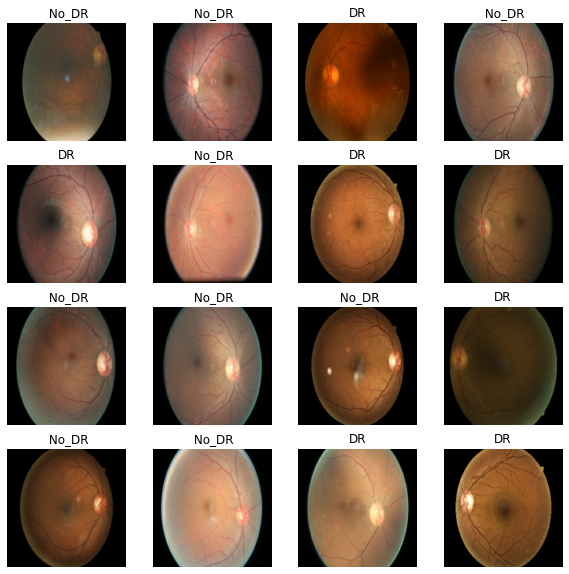

In [13]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

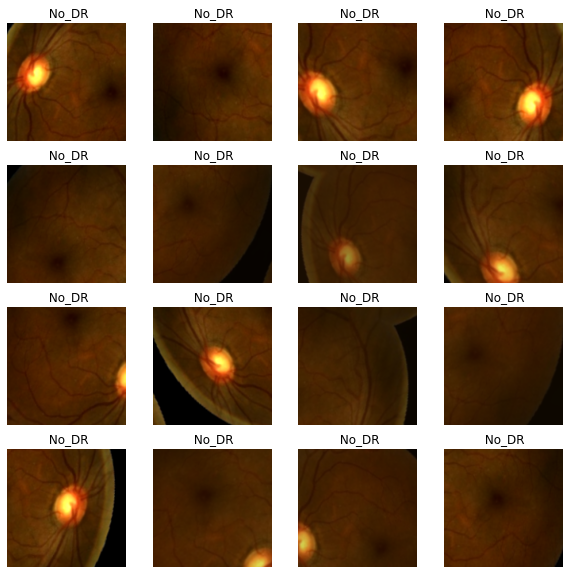

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [19]:
num_classes = len(class_names)

# Transfer Learning

In [20]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.models import Model

In [21]:
base_den = model = DenseNet201(weights='imagenet', include_top=False)
base_den.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

In [22]:
base_den.trainable = False

In [23]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_den(image_batch)
print(feature_batch.shape)

(32, 9, 9, 1920)


In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


In [25]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 8)


In [26]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_den(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
import time
start_cnn = time.time()

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_den.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)

callback_list = [checkpoint,es]

In [30]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/100
226/226 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.5417
Epoch 1: val_accuracy improved from -inf to 0.54545, saving model to best_model_den.hdf5
226/226 [==============================] - 104s 400ms/step - loss: 0.8041 - accuracy: 0.5417 - val_loss: 0.7178 - val_accuracy: 0.5455
Epoch 2/100
226/226 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.5674
Epoch 2: val_accuracy improved from 0.54545 to 0.57910, saving model to best_model_den.hdf5
226/226 [==============================] - 81s 357ms/step - loss: 0.7348 - accuracy: 0.5674 - val_loss: 0.6934 - val_accuracy: 0.5791
Epoch 3/100
226/226 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.5769
Epoch 3: val_accuracy improved from 0.57910 to 0.59592, saving model to best_model_den.hdf5
226/226 [==============================] - 81s 361ms/step - loss: 0.7180 - accuracy: 0.5769 - val_loss: 0.6897 - val_accuracy: 0.5959
Epoch 4/100
226/226 [============

In [31]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  2530.8622398376465 seconds


In [32]:
scores = model.evaluate(train_ds)

226/226 [==============================] - 55s 243ms/step - loss: 0.6887 - accuracy: 0.6185


In [33]:
scores = model.evaluate(val_ds)

97/97 [==============================] - 24s 245ms/step - loss: 0.7302 - accuracy: 0.5966


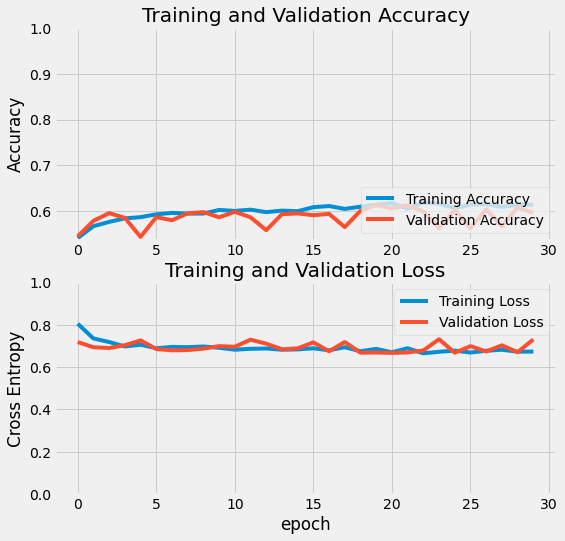

In [34]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label: DR
1/1 [==============================] - 0s 149ms/step
[2.52534598e-01 7.47465253e-01 1.44778456e-08 1.34901015e-08
 1.58019461e-07 2.36714417e-08 1.94645402e-08 6.69411460e-09]
predicted label: DR


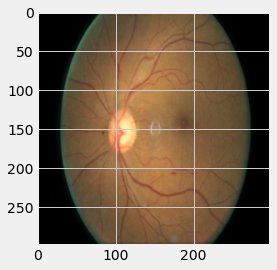

In [39]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[5])
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


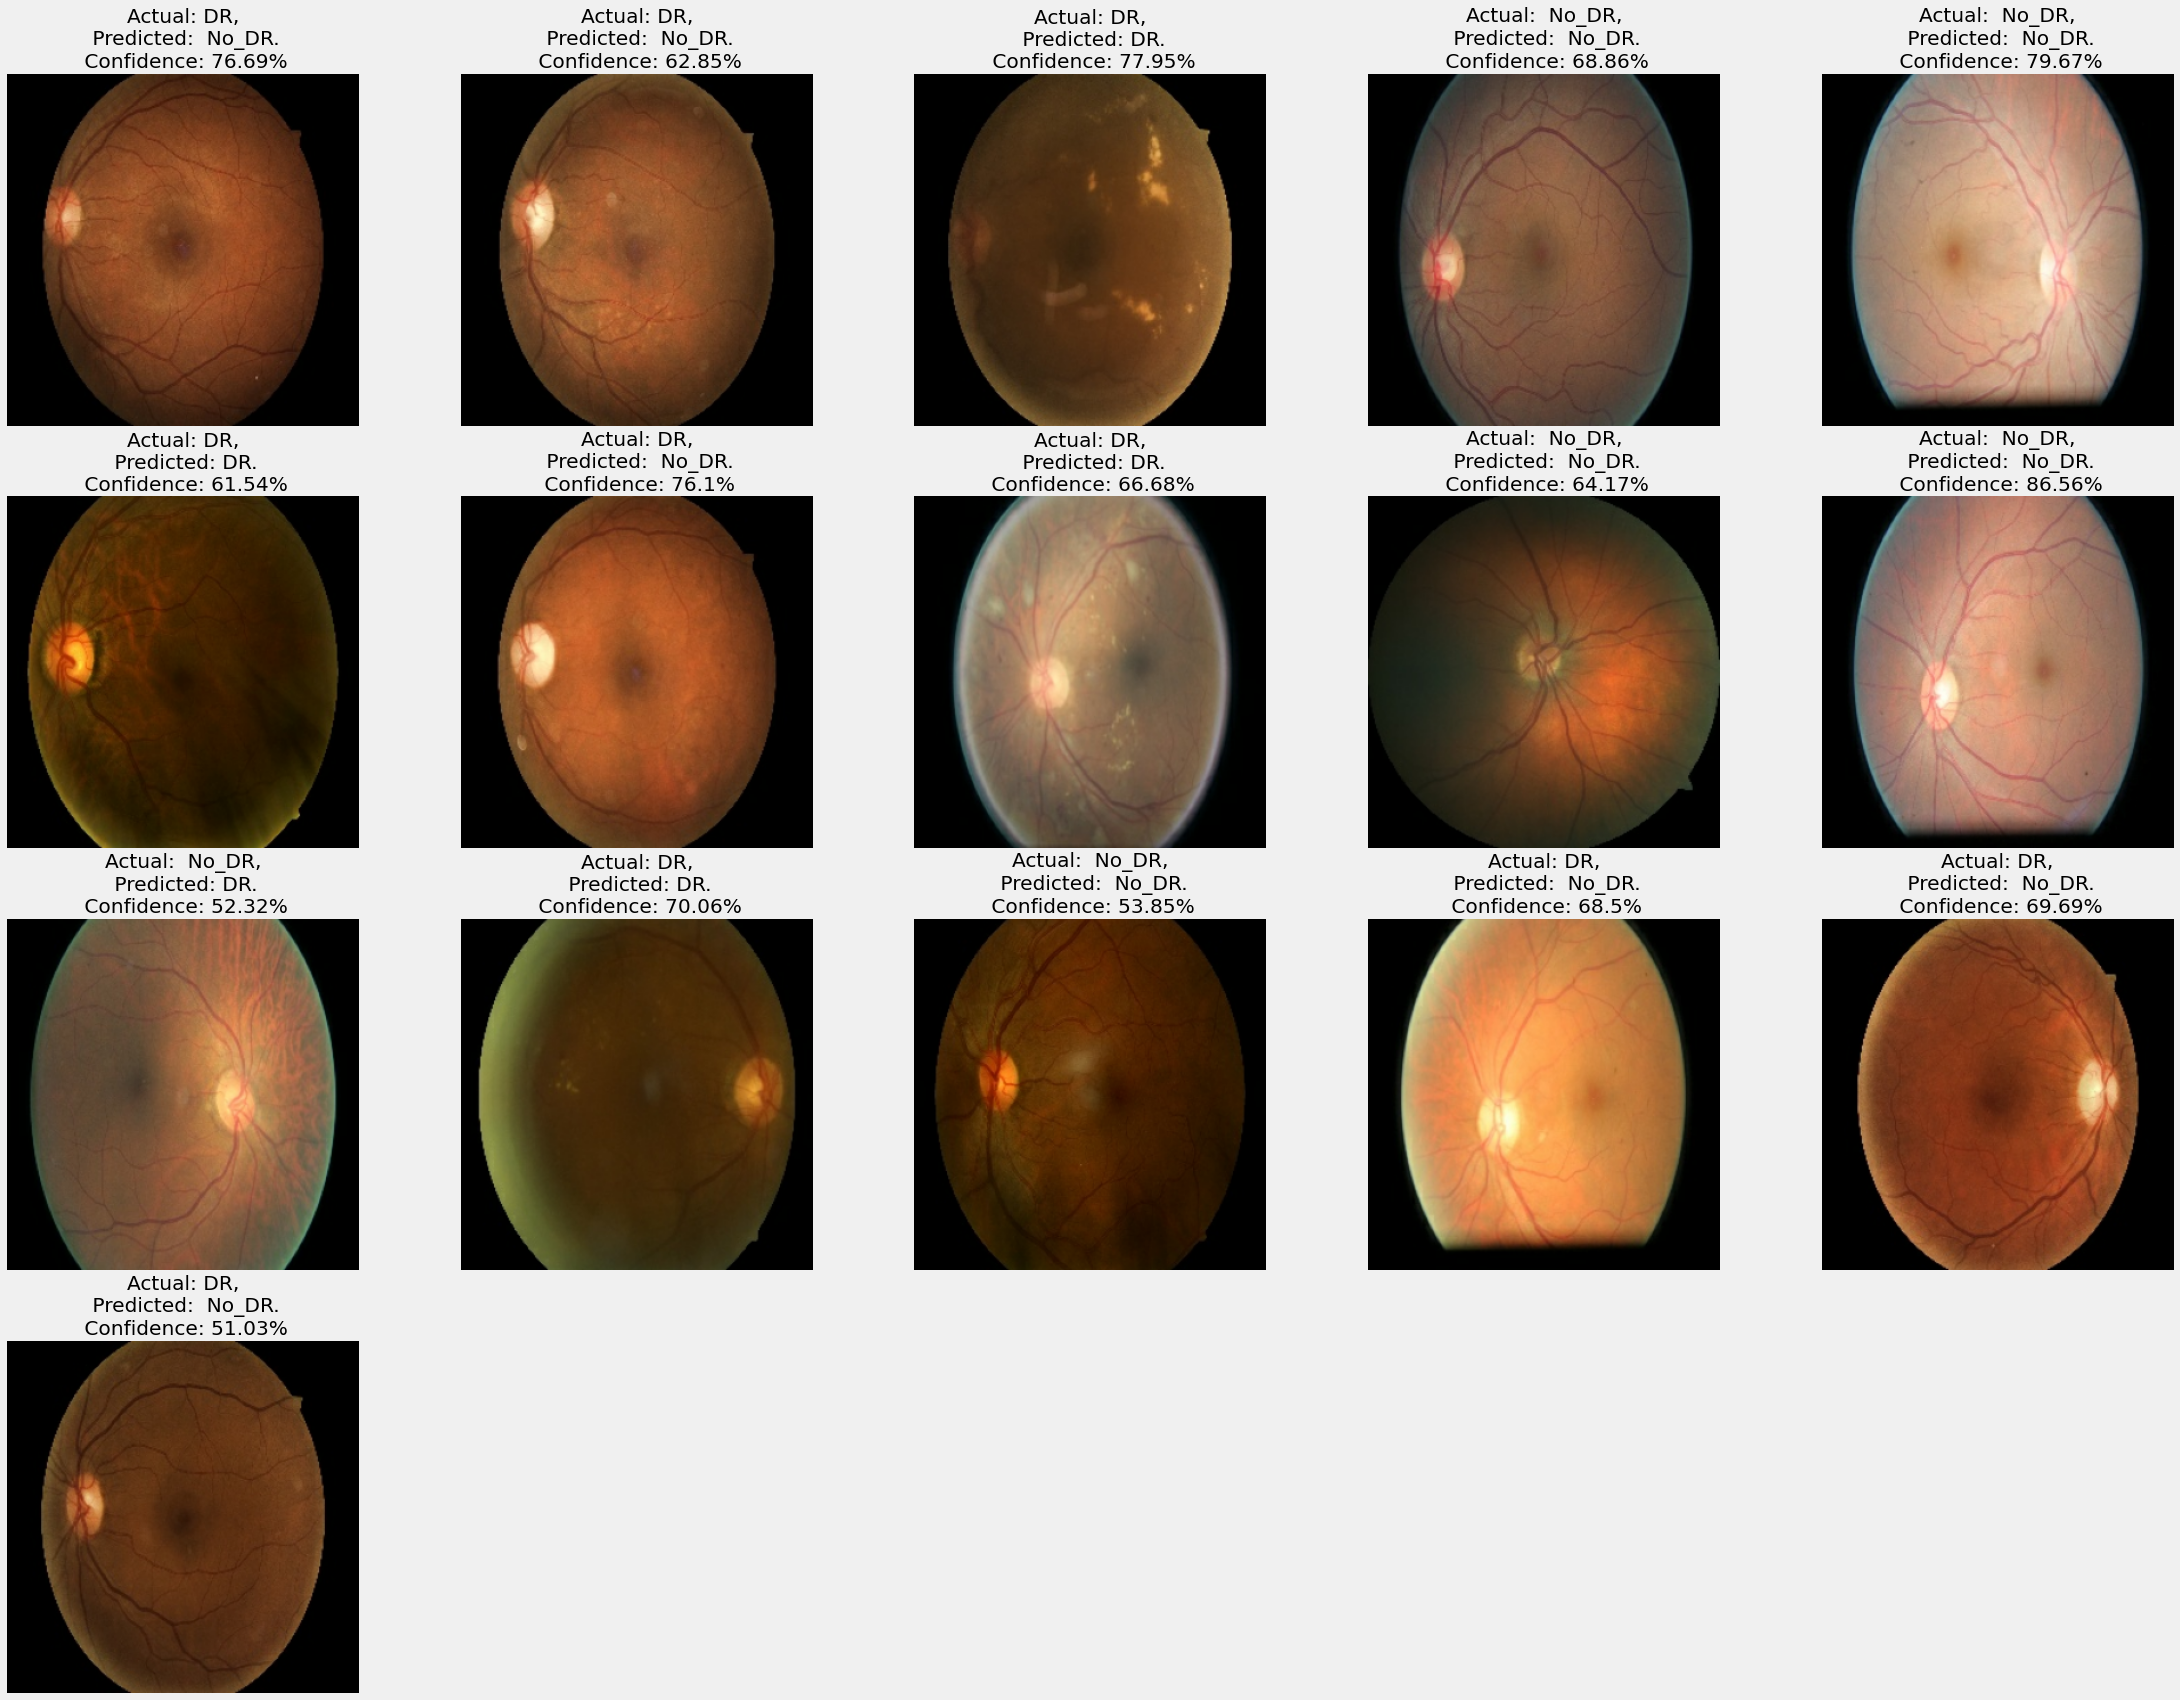

In [41]:
plt.figure(figsize=(35, 35))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [42]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [43]:
x = np.array(X)

In [44]:
y = np.array(y)

In [45]:
x.shape, y.shape

((3059, 299, 299, 3), (3059,))

In [46]:
model.evaluate(x[:3059],y[:3059])

96/96 [==============================] - 23s 237ms/step - loss: 0.7299 - accuracy: 0.5979


[0.7298917174339294, 0.5979078412055969]

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:3059])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:3059], y_pred_classes))